In [1]:
%matplotlib inline
from __future__ import division, print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.detection as afwDetect
import lsst.afw.table as afwTable
import lsst.meas.base as measBase
import lsst.afw.display.utils as dispUtils
import lsst.afw.display.rgb as afwRgb
from toolbox.image import zscale
from skimage.draw import circle as skimage_circle
import lsstutils
plt.style.use('jpg')

In [2]:
data_dir = os.environ.get('LOCAL_DATA')
fn = os.path.join(data_dir, 'calexp-HSC-I-9348-7,6.fits')
exposure = afwImage.ExposureF(fn)
disp  = afwDisplay.Display(1)
mi = exposure.getMaskedImage()
mask = mi.getMask()
psf = exposure.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
mask.clearMaskPlane(mask.getMaskPlane('DETECTED'))

In [3]:
mask.removeAndClearMaskPlane('DETECTED_NEGATIVE', True)
mask.addMaskPlane('HI_THRESH')
mask.addMaskPlane('LO_THRESH');

In [4]:
psf = exposure.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
fwhm = 2*np.sqrt(2*np.log(2))*sigma
ngrow = int(2.4*sigma + 0.5)
mi_smooth = lsstutils.imgproc.smooth_gauss(mi, sigma)
print('psf fwhm =', round(fwhm*0.168, 2), 'arcsec')

psf fwhm = 0.52 arcsec


## High threshold detection 

In [5]:
hi_val = 9.0
HI_THRESH = afwDetect.Threshold(hi_val, afwDetect.Threshold.STDEV)
fp_hi = afwDetect.FootprintSet(mi_smooth, HI_THRESH, 'HI_THRESH')
fp_hi = afwDetect.FootprintSet(fp_hi, ngrow)

## Low threshold detection

In [6]:
lo_val = 2.0
thresh_lo = afwDetect.Threshold(lo_val, afwDetect.Threshold.STDEV)
fp_lo = afwDetect.FootprintSet(mi_smooth, thresh_lo, 'LO_THRESH', 50)
fp_lo = afwDetect.FootprintSet(fp_lo, ngrow)

## Set masks and generate noise array

In [7]:
mask.clearMaskPlane(mask.getMaskPlane('HI_THRESH'))
mask.clearMaskPlane(mask.getMaskPlane('LO_THRESH'))
fp_hi.setMask(mask, 'HI_THRESH') # add high-thresh detections to original mask
fp_lo.setMask(mask, 'LO_THRESH') # add low-thresh detections to original mask
back_rms = mi.getImage().getArray()[mask.getArray()==0].std()
noise_array = back_rms*np.random.randn(mask.getArray().shape[0], mask.getArray().shape[1])
print('bacground rms =', back_rms)

bacground rms = 0.0559639


## Visualize segmentation maps

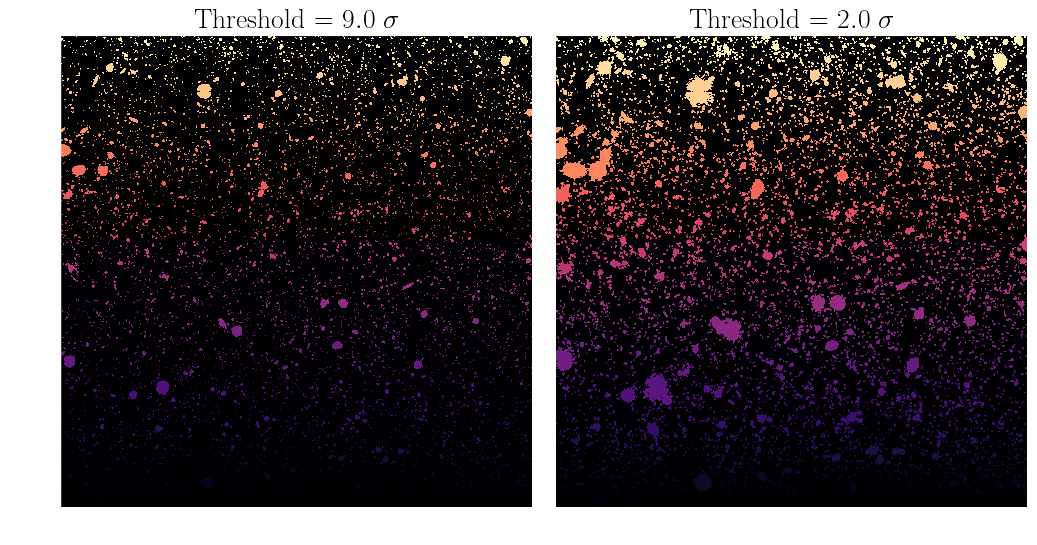

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.05)
seg_hi = fp_hi.insertIntoImage(True).getArray().copy()
seg_lo = fp_lo.insertIntoImage(True).getArray().copy()
seg_maps = [(seg_hi, hi_val), (seg_lo, lo_val)]
for i, (seg, val) in enumerate(seg_maps):
    ax[i].imshow(seg, origin='low', cmap=plt.cm.magma, aspect='equal')
    ax[i].set_axis_off()
    ax[i].set_title('Threshold = $'+str(val)+'\ \sigma$', fontsize=20)            

## Associate low-threshold with high-threshold 

In [9]:
%%time
rmax = 15 # pixels
xy0 = mi.getXY0()
plane_hi = mask.getMaskPlane('HI_THRESH')
bit_hi = mask.getPlaneBitMask('HI_THRESH')
bit_vals = 2**np.arange(mask.getNumPlanesMax())
noise_mask = fp_lo.insertIntoImage(False).getArray().copy()
for i, foot in enumerate(fp_lo.getFootprints()):
    peaks = np.array([p.getCentroid()-xy0 for p in foot.getPeaks()])
    xc, yc = peaks.mean(axis=0)
    rows, cols = skimage_circle(yc, xc, rmax, shape=mask.getArray().shape)
    circ_pix = mask.getArray()[rows, cols]
    on_bits = [bit_hi in bit_vals[(b & bit_vals)!=0] for b in circ_pix]
    if np.sum(on_bits)==0:
        noise_mask[noise_mask==foot.getId()] = 0

CPU times: user 46.5 s, sys: 2.6 s, total: 49.2 s
Wall time: 49.2 s


## Replace sources with noise

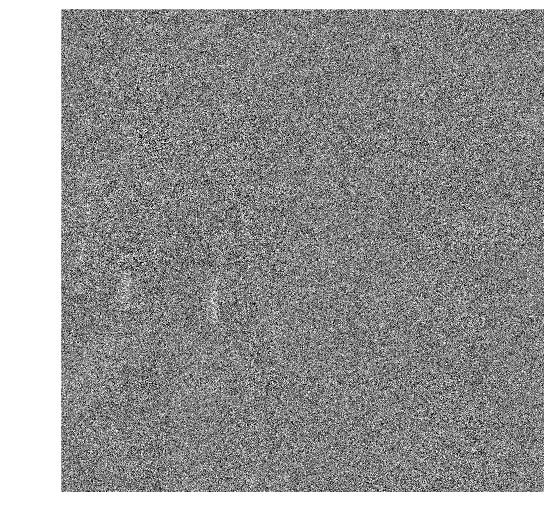

In [10]:
exp_clone = exposure.clone()
mi_clone = exp_clone.getMaskedImage()
mi_clone.getImage().getArray()[noise_mask!=0] = noise_array[noise_mask!=0]
plt.figure(figsize=(6,6))
vmin, vmax = zscale(mi_clone.getImage().getArray())
plt.imshow(mi_clone.getImage().getArray(), vmin=vmin, origin='lower', 
           vmax=vmax, cmap=plt.cm.gray_r, aspect='equal')
plt.axis('off');

## View with ds9

In [11]:
disp.setMaskPlaneColor('HI_THRESH', 'magenta')
disp.setMaskPlaneColor('LO_THRESH', 'yellow')
disp.setMaskTransparency(75)
disp.mtv(mi_clone)

if False:
    with disp.Buffering():
        for foot in fp_hi.getFootprints():
            for p in foot.getPeaks():
                disp.dot('+', p.getCentroid()[0], p.getCentroid()[1], ctype=afwDisplay.GREEN)
        for foot in fp_lo.getFootprints():
            peaks = foot.getPeaks()
            points = np.array([(p.getCentroid()[0],p.getCentroid()[1]) for p in peaks])
            x, y = points.mean(axis=0)
            disp.dot('o', x, y, ctype=afwDisplay.RED)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


## Medium threshold with large kernel

In [12]:
mask_clone = mi_clone.getMask()

In [13]:
fwhm = 4.0/0.168 # pixels
sigma = fwhm/2*np.sqrt(2*np.log(2))
mi_clone_smooth = lsstutils.imgproc.smooth_gauss(mi_clone, sigma)

In [14]:
med_val = 2.5
mask_smooth = mi_clone_smooth.getMask()
mask_smooth.clearMaskPlane(mask_smooth.getMaskPlane('HI_THRESH'))
mask_smooth.clearMaskPlane(mask_smooth.getMaskPlane('LO_THRESH'))
thresh_med = afwDetect.Threshold(med_val, afwDetect.Threshold.STDEV)
fp_med = afwDetect.FootprintSet(mi_clone_smooth, thresh_med, 'DETECTED', 100)
fp_med = afwDetect.FootprintSet(fp_med, 1, True)
fp_med.setMask(mask, 'DETECTED')

In [15]:
disp.setMaskTransparency(50)
disp.mtv(mi)

if False:
    with disp.Buffering():
        for foot in fp_med.getFootprints():
            for p in foot.getPeaks():
                disp.dot('+', p.getCentroid()[0], p.getCentroid()[1], ctype=afwDisplay.YELLOW)
            peaks = foot.getPeaks()
            points = np.array([(p.getCentroid()[0],p.getCentroid()[1]) for p in peaks])
            x, y = points.mean(axis=0)
            disp.dot('o', x, y, ctype=afwDisplay.GREEN)

## Measure stuff

In [16]:
centroidName = "base_SdssCentroid"
shapeName = "base_SdssShape"

schema = afwTable.SourceTable.makeMinimalSchema()
schema.getAliasMap().set("slot_Centroid", centroidName)
schema.getAliasMap().set("slot_Shape", shapeName)
#schema.getAliasMap().set("slot_Centroid_flag", centroidName+"_flag")

control = measBase.GaussianCentroidControl()
centroider = measBase.GaussianCentroidAlgorithm(control, centroidName, schema)

sdssShape = measBase.SdssShapeControl()
shaper = measBase.SdssShapeAlgorithm(sdssShape, shapeName, schema)
table = afwTable.SourceTable.make(schema)

#table.defineCentroid(centroidName)
#table.defineShape(shapeName)

In [17]:
if False:
    with disp.Buffering():
        for foot in fp_lo.getFootprints():
            src = table.makeRecord()
            src.setFootprint(foot)
            centroider.measure(src, exposure)
            shaper.measure(src, exposure) 
            xc, yc = src.getCentroid()
            shape = src.getShape()
            disp.dot("+", xc, yc, ctype=afwDisplay.RED)
            disp.dot(shape, xc, yc, ctype=afwDisplay.RED)

In [18]:
with disp.Buffering():
    disp.erase()
    for parent in fp_lo.getFootprints():
        for peak in parent.getPeaks():
            foot = afwDetect.Footprint(parent)
            foot.getPeaks().clear()
            foot.getPeaks().append(peak)
            
            src = table.makeRecord()
            src.setFootprint(foot)
            centroider.measure(src, exposure)
            shaper.measure(src, exposure) 
            xc, yc = src.getCentroid()
            shape = src.getShape()
            disp.dot("+", xc, yc, ctype=afwDisplay.RED)
            disp.dot(shape, xc, yc, ctype=afwDisplay.RED)

In [19]:
foot.getShape(), foot.getShape().getArea(), foot.getArea()

(Quadrupole(ixx=26.038688077376243, iyy=39.551174213459525, ixy=-1.1869717072767474),
 100.7492544854732,
 381)

In [20]:
msk = mi.getMask()
fps = afwDetect.FootprintSet(msk,
                             afwDetect.Threshold(msk.getPlaneBitMask(['DETECTED']), 
                             afwDetect.Threshold.BITMASK))
disp.erase()
with disp.Buffering():
    for fp in fps.getFootprints():
        dispUtils.drawFootprint(fp, display=disp, XY0=mi.getXY0(), peaks=True)

9


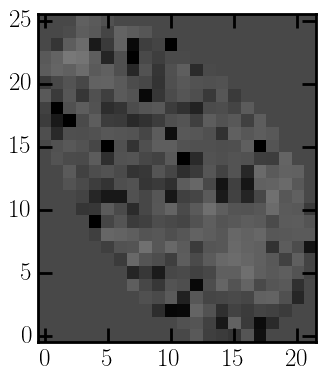

In [22]:
im = mi.Factory(mi, fp.getBBox(), afwImage.PARENT)

im.getImage().getArray()[np.where(im.getMask().getArray() & msk.getPlaneBitMask(['DETECTED',]) == 0)] = 0

fps = afwDetect.FootprintSet(im, afwDetect.Threshold(3, afwDetect.Threshold.STDEV))

print(len(fps.getFootprints()))

if False:
    disp2 = afwDisplay.Display(2)
    disp2.mtv(im)

_ = afwRgb.displayRGB(afwRgb.makeRGB(im, minimum=-0.1, dataRange=0.2))